In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import plot1qbit
from plot1qbit import plot_to_gif
import glob
import h5py
from ipywidgets import interactive
import shutil
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
H5FILE = "debug_data.h5"
H5FILE = "debug_data_offline.h5"

if H5FILE != "debug_data.h5":
    shutil.copyfile("debug_data.h5", H5FILE)

GIF_SKIP = 1000 # number of checkpoints between GIF frames
HEATMAP_STRIDE = 100

R = plot1qbit.report_maker.Report("test_report")
overview = R.new_tab_collection("Overview")
training = R.new_tab_collection("Training")
forward = R.new_tab_collection("Forward")
backward = R.new_tab_collection("Backward")


In [3]:
def get_all_checkpoints_in_order(dataset_template, h5=H5FILE):
    dataset_template = dataset_template.replace("*","")
    with h5py.File(h5, 'r') as F:
        root = "/".join(dataset_template.split('/')[0:-1])
        ds = dataset_template.split('/')[-1]
        keys = [i for i in F[root].keys() if ds in i]
        keys = sorted(keys, key=lambda x: int(x.replace(ds,"")))
        return ["/".join([root, i]) for i in keys]

def plot_single_sample(data, ax):
    ax.imshow(data)
    ax.set_axis_on()
    ax.set_yticks([])
    ax.set_xticks([])  
        
def plot_overview_h5(h5=H5FILE):
    with h5py.File(h5, 'r') as F:
        k = F['backward'].keys()
        trajs = [s.replace("trajectory_chkpt_","") for s in k if "trajectory" in s]
        trajs = sorted(trajs, key=lambda x: int(x))

        Nt = len(trajs)
        N = min(Nt, 10)
        M = int(np.ceil(Nt / N))
        
        print(N, M)

        #M, N = [int(np.ceil(np.sqrt(Nt))),]*2

        count = 0

        fig, ax = plt.subplots(M, N, figsize=(N,M))
        if N==1 or M==1:
            ax = np.reshape(ax, (M, N))

        for m in range(M):
            for n in range(N):
                if count >= Nt:
                    ax[m, n].set_axis_off()
                else:
                    d = F[f'backward/trajectory_chkpt_{trajs[count]}/xs'][-1, ...].squeeze()
                    plot_single_sample(d[np.random.randint(0,d.shape[0])], ax[m, n])
                    if n==0:
                        ax[m, n].set_ylabel(str(trajs[count]), size=8)
                        ax[m, n].set_axis_on()
                        ax[m, n].set_xticks([])
                        ax[m, n].set_yticks([])
                    count+=1
    plt.show()
    return fig

# One terminal sample from each checkpoint

10 3


<IPython.core.display.Javascript object>


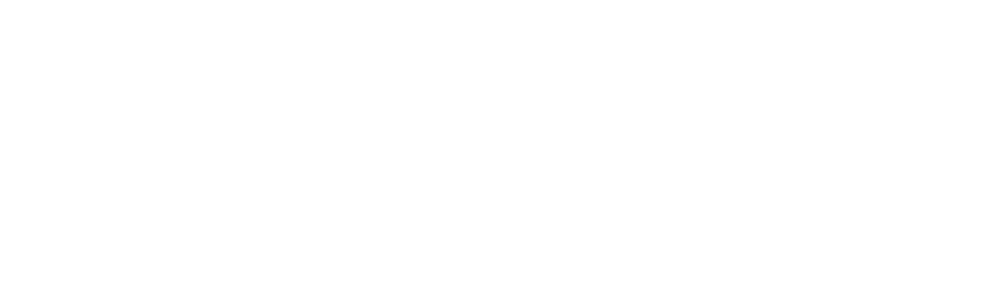

In [4]:
overview.new_tab("Terminal sample from each checkpoint")
overview.add_to_tab(plot_overview_h5(), "Terminal sample from each checkpoint")

# Forward trajectory

<IPython.core.display.Javascript object>


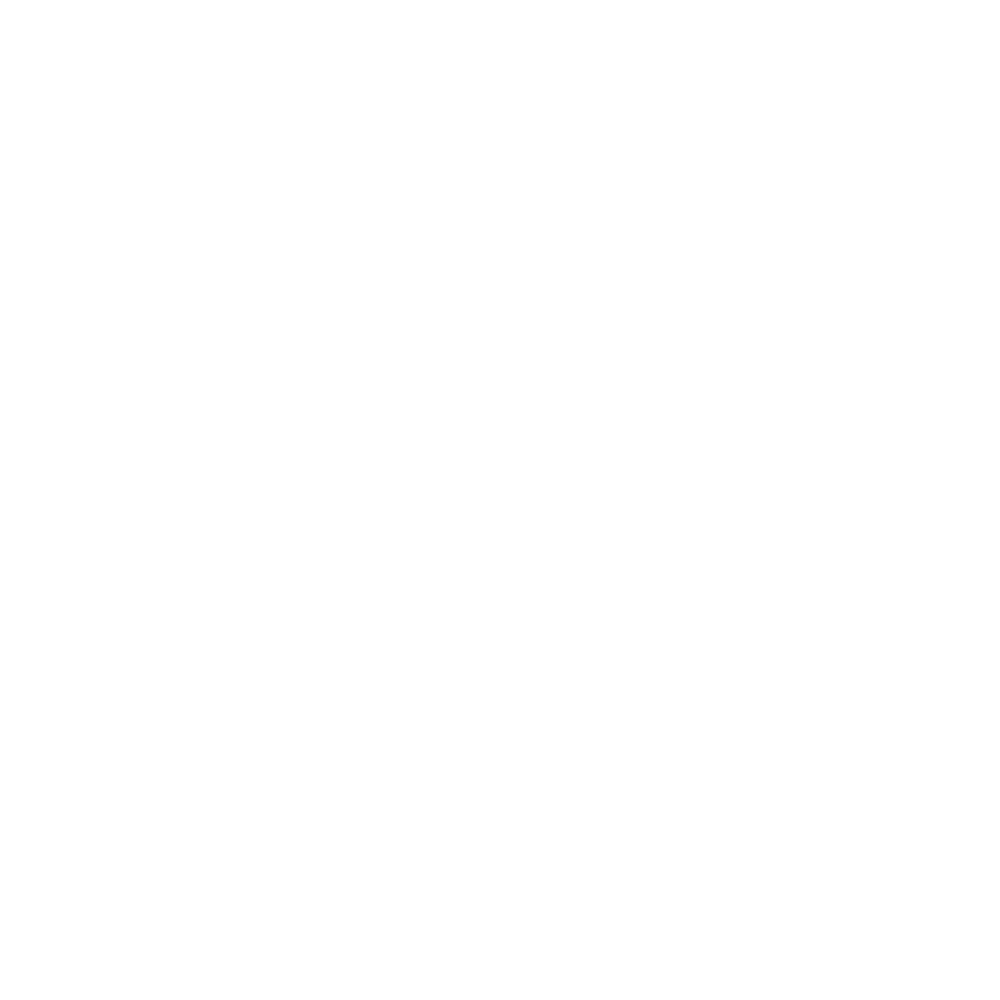

In [5]:
def plot_forward_trajectory(h5=H5FILE, i=0, _stride=10):
    
    with h5py.File(h5, 'r') as F:
        d = F[f'forward/trajectories/{str(i).zfill(5)}/xs'][...]*1.0
        ts = F[f'forward/trajectories/{str(i).zfill(5)}/ts'][...]*1.0
               
    try:
        stride = _stride
    except:
        stride = 10
        
    M, N = ( int(np.ceil(np.sqrt(d.shape[0]/stride))),)*2

    fig, axs = plt.subplots(M, N, figsize=(N, M))

    
    count = 0
    for i in range(M):
        for j in range(N):
            axs[i, j].set_axis_off()
            if count >= d.shape[0]:
                continue
            axs[i, j].imshow(d[count, 0, 0, ...])
            axs[i,j].set_axis_on()
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            if j==0:
                axs[i, j].set_ylabel(str(count), size=8)

            count += stride

    return fig
      
    
        

forward.new_tab("Forward process trajectory")
forward.add_to_tab(plot_forward_trajectory(), "Forward process trajectory")


In [6]:
def plot_forward_terminal_distribution(h5=H5FILE):

    with h5py.File(h5, 'r') as F:
        xs = F['forward/terminal/xTs'][...]*1.0
        ts = F['forward/terminal/ts'][...]*1.0

    mu_T = xs[..., 0].squeeze()
    sigma_T = xs[..., 1].squeeze()

    fig, ax = plt.subplot_mosaic("MS", figsize=(14,5))
    ax['M'].hist(mu_T.flatten(), bins=100)
    ax['S'].hist(sigma_T.flatten(), bins=100)

    ax['M'].set_title("Histogram of $\mu_T$")
    ax['S'].set_title("Histogram of $\sigma_T$")

    fig.show()

    print(f"\\mu_T = \\mathcal{{N}}({mu_T.mean()}, {mu_T.std()})")
    print(f"\\sigma_T = \\mathcal{{N}}({sigma_T.mean()}, {sigma_T.std()})")

    M,N = (10,5)
    fig, axs = plt.subplots(N, M, figsize=(M, N))

    count = 0
    for i in range(N):
        for j in range(M):

            axs[i,j].imshow(xs[count,0,...,0])
            axs[i,j].set_axis_off()

            count += 1

    fig.show()

    M,N = (10,5)
    fig, axs = plt.subplots(N, M, figsize=(M, N))

    count = 0
    for i in range(N):
        for j in range(M):

            axs[i,j].imshow(np.random.randn(8,8))
            axs[i,j].set_axis_off()

            count += 1

    fig.show()
    
    
def plot_forward_terminal_distribution_per_dimension(h5=H5FILE):

    with h5py.File(H5FILE, 'r') as F:
        xs = F['forward/terminal/xTs'][...]*1.0
        ts = F['forward/terminal/ts'][...]*1.0

    mu_T = xs[..., 0].squeeze()
    sigma_T = xs[..., 1].squeeze()
    
    mu_T = mu_T.reshape((mu_T.shape[0], -1))
    sigma_T = sigma_T.reshape((sigma_T.shape[0], -1))
       
    nbins=100   
    X = np.arange(mu_T.shape[-1])
    
    #get the limits based on the first variable:
    _, Y_mu = np.histogram(mu_T[:,0], bins=nbins)
    _, Y_sigma = np.histogram(sigma_T[:,0], bins=nbins)
    #Use these same bins for all other variables:
    mu_dist = [np.histogram(mu_T[:,i], bins=Y_mu)[0][:, np.newaxis] for i in range(mu_T.shape[-1])]
    sigma_dist = [np.histogram(sigma_T[:,i], bins=Y_sigma)[0][:, np.newaxis] for i in range(sigma_T.shape[-1])]
    #transform "bin edges" to Y values by dropping one of them
    Y_mu = Y_mu[1:]
    Y_sigma = Y_sigma[1:]
    
    mu_dist = np.concatenate(mu_dist, axis=1)
    sigma_dist = np.concatenate(sigma_dist, axis=1)
    
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    
    X_mu, Y_mu = np.meshgrid(X, Y_mu)
    axs[0].pcolormesh(X_mu, Y_mu, mu_dist)
    
    X_sigma, Y_sigma = np.meshgrid(X, Y_sigma)
    axs[1].pcolormesh(X_sigma, Y_sigma, sigma_dist)
    
    
    axs[0].set_xlabel("Dimension $i$, as in $x_i$")
    axs[1].set_xlabel("Dimension $i$, as in $x_i$")
    
    axs[0].set_ylabel("Value")
    axs[1].set_ylabel("Value")
    
    axs[0].set_title("$\mu$ distribution for each dimension")
    axs[1].set_title("$\sigma$ distribution for each dimension")
  

#plot_forward_terminal_distribution()
#plot_forward_terminal_distribution_per_dimension()


# Losses

In [7]:
if False:

    with h5py.File(H5FILE, 'r') as F:
        l = F[f'training/losses/loss'][...]
        lc = F[f'training/losses/loss_clamped'][...]
        lr = F[f'training/losses/loss_raw'][...]

        title_data = (("Full loss","Clamped loss", "Raw loss"), (l,lc,lr))

    training.new_tab("Losses")

    for title, data in zip(*title_data):

        fig, ax = plt.subplots(1, 1, figsize=(6, 3))
        xlim = None
        ax.plot(data)
        ax.set_title(f"{title}")
        ax.set_xlim(xlim)
        plt.tight_layout()  

        training.add_to_tab(fig, "Losses")
    


## Importance sampler

In [8]:
def plot_importance_sampler_distribution(h5=H5FILE):

    fig, axs = plt.subplot_mosaic("AAAAAAB", figsize=(10,6))

    logging.info("Reading file")
    with h5py.File(h5, 'r') as F:
        d = F[f'training/importance/pts'][::HEATMAP_STRIDE, ...]
    logging.info("Done reading file")


    X = np.arange(d.shape[0])
    Y = np.arange(d.shape[1])

    logging.info("Plotting pocolormesh")
    axs["A"].pcolormesh(X, Y, d.T, vmin=d[-d.shape[0]//10:, :].min(), vmax=d[-d.shape[0]//10:, :].max())
    logging.info("Done pcolormesh")
    axs["B"].barh(np.arange(d.shape[1]), d[-d.shape[0]//10:, :].mean(axis=0), height=1.0)
    axs["A"].axvline(x=d.shape[0]-d.shape[0]//10, linestyle='--', color='white', alpha=0.5)
    axs["A"].text(0.99, 0.0, "colour scaled to last 10% of data", ha='right', va='bottom', size=10, alpha=0.2, transform=axs["A"].transAxes)

    tmp = d[-d.shape[0]//10: , :].mean(axis=0)
    axs["A"].set_ylim(0,d.shape[1])


    axs["B"].set_ylim(0,d.shape[1])
    axs["B"].text(0.05, 0.5, "last 10% average", color="white", size=20, alpha=0.3, rotation=90, transform=axs["B"].transAxes)

    axs["B"].set_axis_off()

    axs["A"].set_title("Importance sampler distribution")

    axs["A"].set_ylabel("Timestep, $t$")
    axs["A"].set_xlabel("Training step")

    return fig

<IPython.core.display.Javascript object>


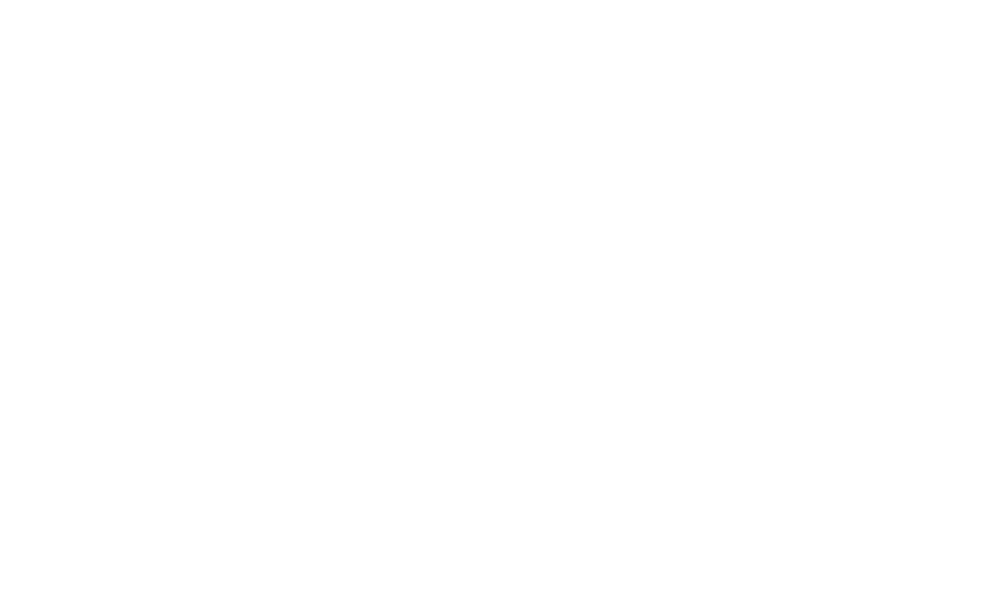

INFO:root:Reading file
INFO:root:Done reading file
INFO:root:Plotting pocolormesh
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  from ipykernel import kernelapp as app
INFO:root:Done pcolormesh


In [9]:


training.new_tab("Importance sampler")
training.add_to_tab(    
    plot_importance_sampler_distribution(h5=H5FILE),
    "Importance sampler"
)

# Backward trajectory

In [10]:
def backward_data_distribution_vs_timestep(chkpt=1000):
    with h5py.File(H5FILE, 'r') as F:
        d = F[f'backward/trajectory_chkpt_{chkpt}/xs'][...]
        #d[np.isnan(d)] = 0

    ylim=(-10,10)    

    bins=100
    T = d.shape[0]
    histdata = np.zeros((T, bins))

    for t in range(T):
        histdata[t,:], edges = np.histogram(d[t, ...].flatten(), bins=100, range=ylim)

    stds = np.std(d.reshape((d.shape[0], -1)), axis=1)
    means = np.mean(d.reshape((d.shape[0], -1)), axis=1)

    X, Y = np.meshgrid(np.arange(T), edges[1:])

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "",
        np.concatenate([["white", "blue", "C4"] for i in range(5)]) )
    

    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    ax.grid(False)
    ax.pcolormesh(X, Y, histdata.T, cmap=cmap)

    ax.plot(np.arange(T), stds, '--', color='C4', label='Standard deviation', alpha=0.5)
    ax.plot(np.arange(T), -stds, '--', color='C4', alpha=0.5)
    ax.plot(np.arange(T), means, '--', color='C2', label='Mean', alpha=0.5)
    
    ax.text(1.0, 0.0, f"step {chkpt}", va='bottom', ha='right', size=50, alpha=0.07, transform=ax.transAxes)

    ax.legend()

    ax.set_title(f"Backward process data distribution, checkpoint {chkpt}")

    ax.set_xlabel("Backward timestep")
    ax.set_ylabel("Data value")

    ax.set_ylim(ylim)
    
    return fig


#steps = range(1000,7000,1000)
#x = plot_to_gif(func=backward_data_distribution_vs_timestep, ts=steps, gif_params={"duration":500, "unit":'ms', "between":'frames'}, return_image=False)


#frames = [backward_data_distribution_vs_timestep(t) for t in tqdm(range(*steps))]
#gif.save(frames,"backward_data_distribution_vs_timestep.gif", duration=1000, unit='ms', between='frames')   

#Image("backward_data_distribution_vs_timestep.gif")

#interactive_plot = interactive(backward_data_distribution_vs_timestep, chkpt=steps)
#interactive_plot

In [11]:
%%capture

most_recent_checkpoint = int(get_all_checkpoints_in_order("backward/trajectory_chkpt_*")[-1].split("_")[-1]) 
backward.new_tab("Data distribution")
backward.add_to_tab(backward_data_distribution_vs_timestep(chkpt=most_recent_checkpoint), "Data distribution")

checkpoint_freq = GIF_SKIP # how often checkpoints are saved (or how often you want plotted)
backward.add_to_tab(plot_to_gif(func=backward_data_distribution_vs_timestep, ts=range(1000, most_recent_checkpoint+1, checkpoint_freq), gif_params={"duration":500, "unit":'ms', "between":'frames'}, return_image=False, gif_filename="temp_gif.gif"))
    

In [12]:
def backward_data_trajectory(chkpt=1000):

    with h5py.File(H5FILE, 'r') as F:
        d = F[f'backward/trajectory_chkpt_{chkpt}/xs'][...]
        #d[np.isnan(d)] = 0

    
    try:
        stride = _stride
    except:
        stride = 10
        
    M, N = ( int(np.ceil(np.sqrt(d.shape[0]/stride))),)*2

    fig, axs = plt.subplots(M, N, figsize=(N, M))

    
    count = 0
    for i in range(M):
        for j in range(N):
            axs[i, j].set_axis_off()
            if count >= d.shape[0]:
                continue
            axs[i, j].imshow(d[count, 0, 0, ...])
            axs[i,j].set_axis_on()
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            if j==0:
                axs[i, j].set_ylabel(str(count), size=8)

            count += stride

    axs[-1,-1].text(1.0, 0.0, f"step {chkpt}", va='bottom', ha='right', size=50, alpha=0.1, transform=axs[-1,-1].transAxes)
    
    return fig



In [13]:
%%capture

most_recent_checkpoint = int(get_all_checkpoints_in_order("backward/trajectory_chkpt_*")[-1].split("_")[-1]) 


backward.new_tab("Data samples")

_stride=1
backward.add_to_tab(backward_data_trajectory(chkpt=most_recent_checkpoint), "Data samples")

_stride = 10
checkpoint_freq = GIF_SKIP
backward.add_to_tab(
    plot_to_gif(func=backward_data_trajectory,
                ts=range(1000,most_recent_checkpoint+1, checkpoint_freq),
                gif_params={"duration":500, "unit":'ms', "between":'frames'},
                return_image=False,
                gif_filename="temp_gif.gif"),
    "Data samples")


# Score function distribution

In [14]:
def score_function_distribution_vs_timestep(chkpt=1000, h5=H5FILE):
    with h5py.File(h5, 'r') as F:
        d = F[f'backward/score_evaluation_chkpt_{chkpt}/score'][...]
        infs = d==np.inf
        d[infs] = np.nanmax(d[~infs])
        
    
    ylim=(np.nanmin(d), np.nanmax(d))
    #ylim=(-1,1)

    bins=50
    T = d.shape[0]
    histdata = np.zeros((T, bins))

    for t in range(T):
        histdata[t,:], edges = np.histogram(d[t, ...].flatten(), bins=bins, range=ylim)

    stds = np.std(d.reshape((d.shape[0], -1)), axis=1)
    means = np.mean(d.reshape((d.shape[0], -1)), axis=1)

    X, Y = np.meshgrid(np.arange(T), edges[1:])
    
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    ax.grid(False)
    ax.pcolormesh(X, Y, histdata.T)#, cmap='1qbit5')

    ax.plot(np.arange(T), stds, '--', color='C1', label='Standard deviation', alpha=0.1)
    ax.plot(np.arange(T), -stds, '--', color='C1', alpha=0.1)
    ax.plot(np.arange(T), means, '--', color='C1', label='Mean', alpha=0.1)
    
    ax.text(1.0, 0.0, f"step {chkpt}", va='bottom', ha='right', size=50, alpha=0.07, transform=ax.transAxes)

    ax.legend()

    ax.set_title(f"Backward process score function distribution, checkpoint {chkpt}")

    ax.set_xlabel("Backward timestep")
    ax.set_ylabel("Data value")

    ax.set_ylim(ylim)

    return fig

In [ ]:
%%capture

most_recent_checkpoint = int(get_all_checkpoints_in_order("backward/score_evaluation_chkpt_*")[-1].split("_")[-1]) 
backward.new_tab("Score function distribution")
backward.add_to_tab(score_function_distribution_vs_timestep(chkpt=most_recent_checkpoint))

checkpoint_freq = GIF_SKIP # how often checkpoints are saved (or how often you want plotted)
backward.add_to_tab(
    plot_to_gif(func=score_function_distribution_vs_timestep, 
                ts=range(1000, most_recent_checkpoint+1, checkpoint_freq), 
                gif_params={"duration":500, "unit":'ms', "between":'frames'}, 
                return_image=False, 
                gif_filename="temp_gif.gif"))
    

In [ ]:
def plot_score_function_scaler_distribution(h5=H5FILE, terminal_step=None):

    fig, axs = plt.subplot_mosaic("AAAAAAB", figsize=(10,6))

    
    with h5py.File(h5, 'r') as F:
        d = F[f'training/score_scaler/scaler'][::HEATMAP_STRIDE, ...]    


    X = np.arange(d.shape[0])
    Y = np.arange(d.shape[1])


    axs["A"].pcolormesh(X, Y, d.T)
    axs["B"].barh(np.arange(d.shape[1]), d[-d.shape[0]//10:, :].mean(axis=0), height=1.0)
    axs["A"].axvline(x=d.shape[0]-d.shape[0]//10, linestyle='--', color='white', alpha=0.5)
    axs["A"].text(0.99, 0.0, "colour scaled to last 10% of data", ha='right', va='bottom', size=10, alpha=0.2, transform=axs["A"].transAxes)

    tmp = d[-d.shape[0]//10: , :].mean(axis=0)
    axs["A"].set_ylim(0,d.shape[1])


    axs["B"].set_ylim(0,d.shape[1])
    axs["B"].text(0.05, 0.5, "last 10% average", color="white", size=20, alpha=0.3, rotation=90, transform=axs["B"].transAxes)

    axs["B"].set_axis_off()

    axs["A"].set_title("Score function scaler distribution")

    axs["A"].set_ylabel("Timestep, $t$")
    axs["A"].set_xlabel("Score function evaluation")

    return fig

In [ ]:
%%capture

training.new_tab("Score function scaler")
training.add_to_tab(    
plot_score_function_scaler_distribution(h5=H5FILE, terminal_step=None),
    "Score function scaler"
)

In [ ]:
def cleaninf(d):
    infs = d==np.inf
    d[infs] = np.nanmax(d[~infs])
    
    ninfs = d==-np.inf
    d[ninfs] = np.nanmin(d[~ninfs])
    return d

def backward_score_x_trajectory(chkpt=1000, h5=H5FILE):

    with h5py.File(h5, 'r') as F:
        d_xs = F[f'backward/score_evaluation_chkpt_{chkpt}/xs'][...]
        d_sc = F[f'backward/score_evaluation_chkpt_{chkpt}/score'][...]
        #d[np.isnan(d)] = 0
        
        d_sc = cleaninf(d_sc)
        d_xs = cleaninf(d_xs)
        
    stride = 10
    
    d_xs_range = dict(vmin=-1, vmax=1)
        
    num = d_xs.shape[0] // stride
    
    N = min(10, num)
    M = 2*int(np.ceil(num/10))
    

    

    fig, axs1 = plt.subplots(M, N, figsize=(N, M))

    t = 0

    for i in range(0, M, 2):
        
        axs1[i,0].set_ylabel(f"$x_{{{t}}}$")
        axs1[i+1,0].set_ylabel(f"$s_\\theta(x_{{{t}}})$", size=8)
        
        for j in range(N):
            if t >= d_xs.shape[0]:
                continue
            axs1[i,j].imshow(d_xs[t, 0, 0, ...], **d_xs_range )
            axs1[i,j].set_axis_on()
            axs1[i,j].set_xticks([])
            axs1[i,j].set_yticks([])
            
            axs1[i+1, j].imshow(d_sc[t, 0, 0, ...], vmin=np.nanmin(d_sc), vmax=np.nanmax(d_sc), cmap="Reds")
            axs1[i+1, j].set_axis_on()
            axs1[i+1, j].set_xticks([])
            axs1[i+1, j].set_yticks([])
            
            t += stride
        
    return fig

    

In [ ]:
backward.new_tab("Score function input-output")
most_recent_checkpoint = int(get_all_checkpoints_in_order("backward/score_evaluation_chkpt_*")[-1].split("_")[-1])

#backward_score_x_trajectory(chkpt=most_recent_checkpoint).show()
backward.add_to_tab(backward_score_x_trajectory(chkpt=most_recent_checkpoint))

In [ ]:
R.add_content(overview)
R.add_content(training)
R.add_content(forward)
R.add_content(backward)
R.write()

In [ ]:
import os
os.remove("debug_data_offline.h5")